In [1]:
from train_test import train, test

from sklearn.model_selection import train_test_split
import torch
import numpy as np
import pandas as pd
from torch import nn
import torch
import torch.nn.functional as F
import math
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import pylab as pl

from dateutil.relativedelta import relativedelta

import shap

from captum.attr import IntegratedGradients, ShapleyValues, ShapleyValueSampling, LayerConductance

from tqdm.notebook import tqdm

import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

torch.manual_seed(0)
np.random.seed(0)

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import MinMaxScaler

In [3]:
def output_to_accu(model, X, y):
    model.eval()
    prob = model(X).cpu().detach().numpy()
    index = np.where((prob > 0.5) | (prob < 0.5))
    prob = prob[index]
    y = y[index]
    pred = (prob >= 0.5).astype(int)
    nb_errors = 0
    for b in range(0, len(y)):
        if pred[b] != y[b]:
            nb_errors = nb_errors + 1
    accuracy = 100 * (1 - nb_errors / len(y))
    return accuracy

In [4]:
def output_to_accu_sklearn(model, X, y):
    prob = model.predict_proba(X)[:, 1]
    index = np.where((prob > 0.55) | (prob < 0.45))
    prob = prob[index]
    y = y[index]
    pred = (prob >= 0.5).astype(int)
    nb_errors = 0
    for b in range(0, len(y)):
        if pred[b] != y[b]:
            nb_errors = nb_errors + 1
    accuracy = (1 - nb_errors / len(y))
    return accuracy

In [5]:
def good_bad_pred(model, X_test, y_test):
    model.eval()
    prob = model(X_test).detach().numpy()
    pred = (prob >= 0.5).astype(int)
    return (pred == y_test.detach().numpy()).astype(int)

In [6]:
def good_bad_pred_sklearn(model, X_test, y_test):
    pred = model.predict(X_test)
    return (pred == y_test).astype(int)

In [7]:
def fast_fracdiff(x, d):
    T = len(x)
    np2 = int(2 ** np.ceil(np.log2(2 * T - 1)))
    k = np.arange(1, T)
    b = (1,) + tuple(np.cumprod((k - d - 1) / k))
    z = (0,) * (np2 - T)
    z1 = b + z
    z2 = tuple(x) + z
    dx = pl.ifft(pl.fft(z1) * pl.fft(z2))
    return np.real(dx[0:T])

In [8]:
def log_change(x):
    return np.log(x[-1] / x[0]) / len(x)

def pct_change(x):
    return (x[-1] - x[0]) / x[0]

In [9]:
red = sns.color_palette('RdYlGn', 10)[0]
green = sns.color_palette('RdYlGn', 10)[-1]
pal = [red, green]
color_dict = {'Bad':pal[0], 'Good':pal[1]}

# DATA

In [10]:
data = pd.read_excel('data/data.xlsx', index_col=0, skiprows=[0, 1, 2, 3, 4, 5, 6, 8], sheet_name='features').astype(float)
data = data.fillna(method='ffill').shift(1).iloc[1:]
data = data.loc[:'2020-01-01']

data['MATERIALS'] *= data['EURCHF']
data['CONSUMER STAPLE'] *= data['EURCHF']
data['INDUSTRIALS'] *= data['EURCHF']
data['CONSUMER DIS.'] *= data['EURCHF']
data['HEALTH CARE'] *= data['EURCHF']
data['FINANCIALS'] *= data['EURCHF']

data['GOLD'] *= data['USDCHF']
data['SILVER'] *= data['USDCHF']
data['BRENT'] *= data['USDCHF']
data['SP500'] *= data['USDCHF']
data['RUSSELL 2000'] *= data['USDCHF']

bench_price = data['SPI']

data = data.drop(columns=['EURCHF', 'USDCHF', 'SPI'])

data.head()

,SMALL_MID,LARGE,MATERIALS,CONSUMER STAPLE,INDUSTRIALS,CONSUMER DIS.,HEALTH CARE,FINANCIALS,US 2YEAR,US 5YEAR,US 10YEAR,GOLD,SILVER,BRENT,SP500,RUSSELL 2000,SURPRISE,VSMI,VIX
2006-01-05,1508.31,5833.18,276.409672,174.241453,218.695382,140.386529,175.355509,174.721116,4.304,4.277,4.344,679.214800,11.605220,78.703680,1624.934960,879.509796,24.4,13.04,11.37
2006-01-06,1509.53,5818.60,272.864640,172.733945,217.021928,139.568162,175.452705,173.846165,4.321,4.284,4.354,672.828960,11.181886,78.075236,1626.488656,883.552911,28.2,13.22,11.31
2006-01-09,1516.33,5828.32,274.390587,173.003134,217.791843,140.132384,175.331222,174.622003,4.354,4.316,4.375,685.399920,11.463555,79.666944,1632.778590,888.382961,25.3,13.10,11.00
2006-01-10,1518.68,5823.36,274.741194,172.954918,217.963610,140.964506,175.453688,175.052650,4.345,4.302,4.367,699.485820,11.715558,79.180569,1647.392535,901.822117,26.3,13.53,11.13
2006-01-11,1512.24,5785.15,271.683725,173.365830,217.371702,140.438683,174.153856,173.844827,4.395,4.358,4.426,694.241856,11.468668,79.300944,1651.705983,910.590507,26.4,14.18,10.86


In [11]:
target_prices = data[['SMALL_MID', 'LARGE']]
target_prices.head()

,SMALL_MID,LARGE
2006-01-05,1508.31,5833.18
2006-01-06,1509.53,5818.60
2006-01-09,1516.33,5828.32
2006-01-10,1518.68,5823.36
2006-01-11,1512.24,5785.15


In [84]:
technical_features = data[['SMALL_MID', 'LARGE']]

mom5 = technical_features.rolling(5).apply(lambda x: log_change(x))
mom5 = mom5.add_suffix(' mom5')

mom21 = technical_features.rolling(21).apply(lambda x: log_change(x))
mom21 = mom21.add_suffix(' mom21')

mom63 = technical_features.rolling(63).apply(lambda x: log_change(x))
mom63 = mom63.add_suffix(' mom63')

vol21 = technical_features.pct_change().rolling(21).std()
vol21 = vol21.add_suffix(' vol21')

skew21 = technical_features.pct_change().rolling(21).skew()
skew21 = skew21.add_suffix(' skew21')

corr = target_prices.SMALL_MID.pct_change().rolling(21).corr(target_prices.LARGE.pct_change()).rename('correlation')

features = pd.DataFrame(index=technical_features.index)
for feature in ['MATERIALS', 'SP500', 'BRENT', 'FINANCIALS', 'GOLD', 'US 5YEAR', 
                                'US 2YEAR', 'INDUSTRIALS', 'US 10YEAR', 'CONSUMER DIS.', 'HEALTH CARE', 
                                'CONSUMER STAPLE', 'RUSSELL 2000', 'SILVER']:
    #features[feature] = fast_fracdiff(data[feature], 0.5)
    features[feature] = data[feature].rolling(5).apply(lambda x: log_change(x))

features = pd.concat([mom5, mom21, mom63, vol21, skew21, corr, features, data[['SURPRISE', 'VSMI', 'VIX']]], axis=1).ewm(5).mean().dropna()

features.head(5)

,SMALL_MID mom5,LARGE mom5,SMALL_MID mom21,LARGE mom21,SMALL_MID mom63,LARGE mom63,SMALL_MID vol21,LARGE vol21,SMALL_MID skew21,LARGE skew21,correlation,MATERIALS,SP500,BRENT,FINANCIALS,GOLD,US 5YEAR,US 2YEAR,INDUSTRIALS,US 10YEAR,CONSUMER DIS.,HEALTH CARE,CONSUMER STAPLE,RUSSELL 2000,SILVER,SURPRISE,VSMI,VIX
2006-04-03,0.001734,-0.000138,0.001987,0.000582,0.001972,0.000648,0.004805,0.005994,-0.681978,0.413390,0.550245,0.002142,-0.000306,0.004831,0.000012,0.003677,0.002804,0.002220,0.001047,0.002904,0.000693,-0.000045,-0.000726,0.002206,0.007500,-5.650111,12.005423,11.450572
2006-04-04,0.001879,0.000316,0.002005,0.000638,0.002031,0.000723,0.004822,0.005864,-0.677942,0.450865,0.549831,0.002988,-0.000034,0.005074,0.000644,0.004428,0.002669,0.002203,0.001774,0.002987,0.000980,0.000287,-0.000390,0.002292,0.009026,-4.391748,11.984519,11.470477
2006-04-05,0.002176,0.000543,0.002121,0.000708,0.002041,0.000715,0.004835,0.005769,-0.674858,0.486732,0.547301,0.003563,-0.000435,0.004168,0.000875,0.004309,0.002363,0.001960,0.002144,0.002903,0.000936,0.000160,-0.000256,0.001344,0.009227,-3.009780,11.990433,11.415397
2006-04-06,0.002428,0.000679,0.002302,0.000829,0.002060,0.000741,0.004711,0.005658,-0.614796,0.501623,0.533222,0.003521,-0.000464,0.003403,0.000808,0.003512,0.001699,0.001412,0.002026,0.002336,0.000755,-0.000080,-0.000380,0.000890,0.008279,-1.824810,11.998694,11.367831
2006-04-07,0.002594,0.000873,0.002454,0.000916,0.002100,0.000792,0.004508,0.005548,-0.487867,0.501397,0.515718,0.003883,-0.000382,0.003438,0.000878,0.003212,0.001589,0.001301,0.001985,0.002303,0.000671,-0.000235,-0.000522,0.000429,0.007813,-0.754003,11.987245,11.381526


# Train-Validation dataset

In [85]:
neutral_threshold = 0.0005

forward_weekly_returns = target_prices.rolling(5).apply(lambda x: np.log(x[-1] / x[0]) / len(x)).shift(-5)
forward_weekly_returns['difference'] = forward_weekly_returns.SMALL_MID - forward_weekly_returns.LARGE
forward_weekly_returns['abs_diff'] = np.abs(forward_weekly_returns.difference)

best_pred = (forward_weekly_returns.SMALL_MID > forward_weekly_returns.LARGE).astype(int)
best_pred = best_pred[forward_weekly_returns.abs_diff > neutral_threshold]

start_date = '2009-01-01'
end_date = '2013-11-20'

df_output = best_pred.loc[start_date:end_date]
df_input = features.reindex(df_output.index)

index = df_output.index
# features = features.reindex(index)
features_std = pd.DataFrame(data=PowerTransformer(method='yeo-johnson', standardize=True).fit_transform(df_input), 
                            columns=features.columns,
                            index=df_input.index)

# CORRELATION

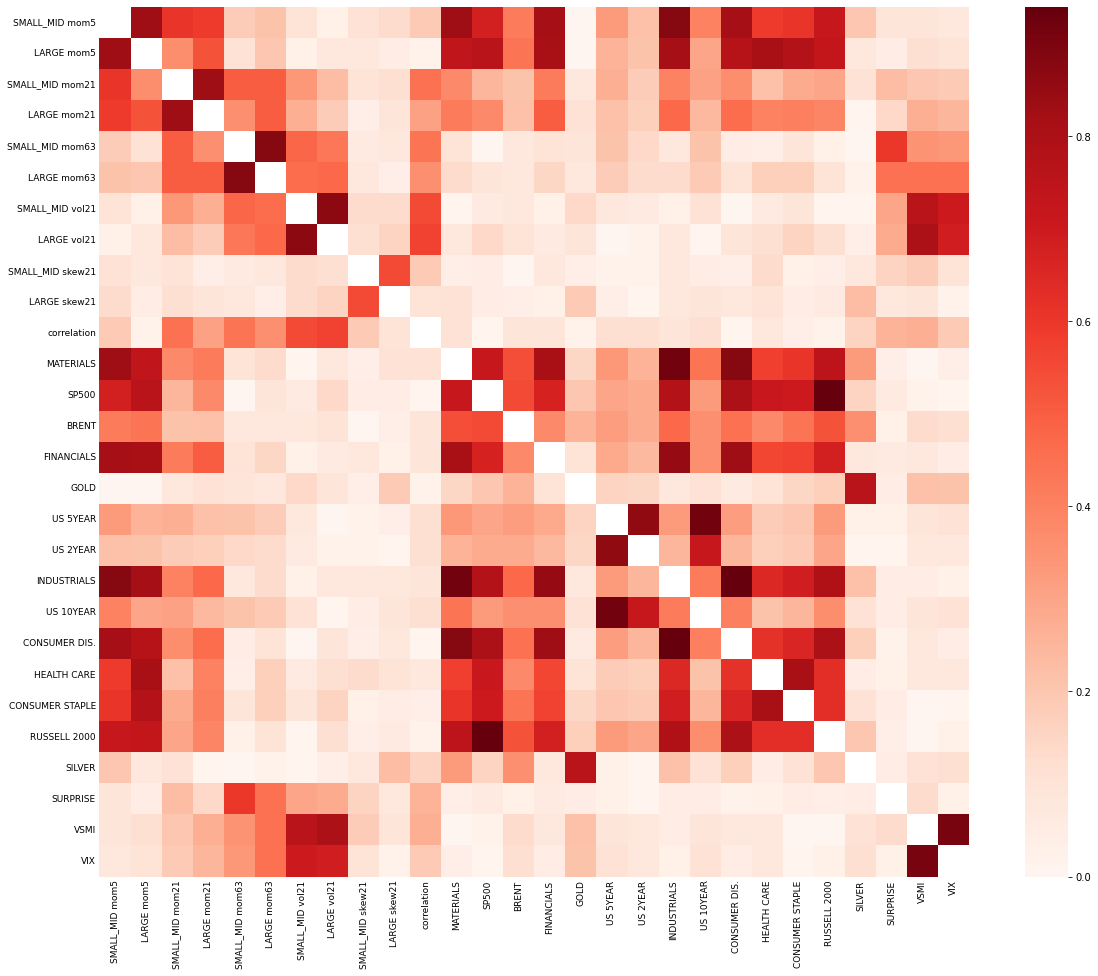

In [86]:
corr = features_std.corr().abs().round(2)

fig, ax = plt.subplots(figsize=(20, 16))
mask = np.identity(len(corr))
sns.heatmap(data=corr, annot=False, cmap='Reds', cbar=True, mask=mask, annot_kws=dict(size=12), square=True)
ax.tick_params(axis='both', which='major', labelsize=9, labelbottom=True, labeltop=False, labelleft=True, length=0)
plt.savefig('plots/latex/correlation_matrix.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [87]:
corr_stack = corr.stack()
corr_stack[corr_stack.gt(0.9) & (corr_stack != 1.)]

MATERIALS      INDUSTRIALS      0.92
SP500          RUSSELL 2000     0.94
US 5YEAR       US 10YEAR        0.92
INDUSTRIALS    MATERIALS        0.92
               CONSUMER DIS.    0.94
US 10YEAR      US 5YEAR         0.92
CONSUMER DIS.  INDUSTRIALS      0.94
RUSSELL 2000   SP500            0.94
VSMI           VIX              0.91
VIX            VSMI             0.91
dtype: float64

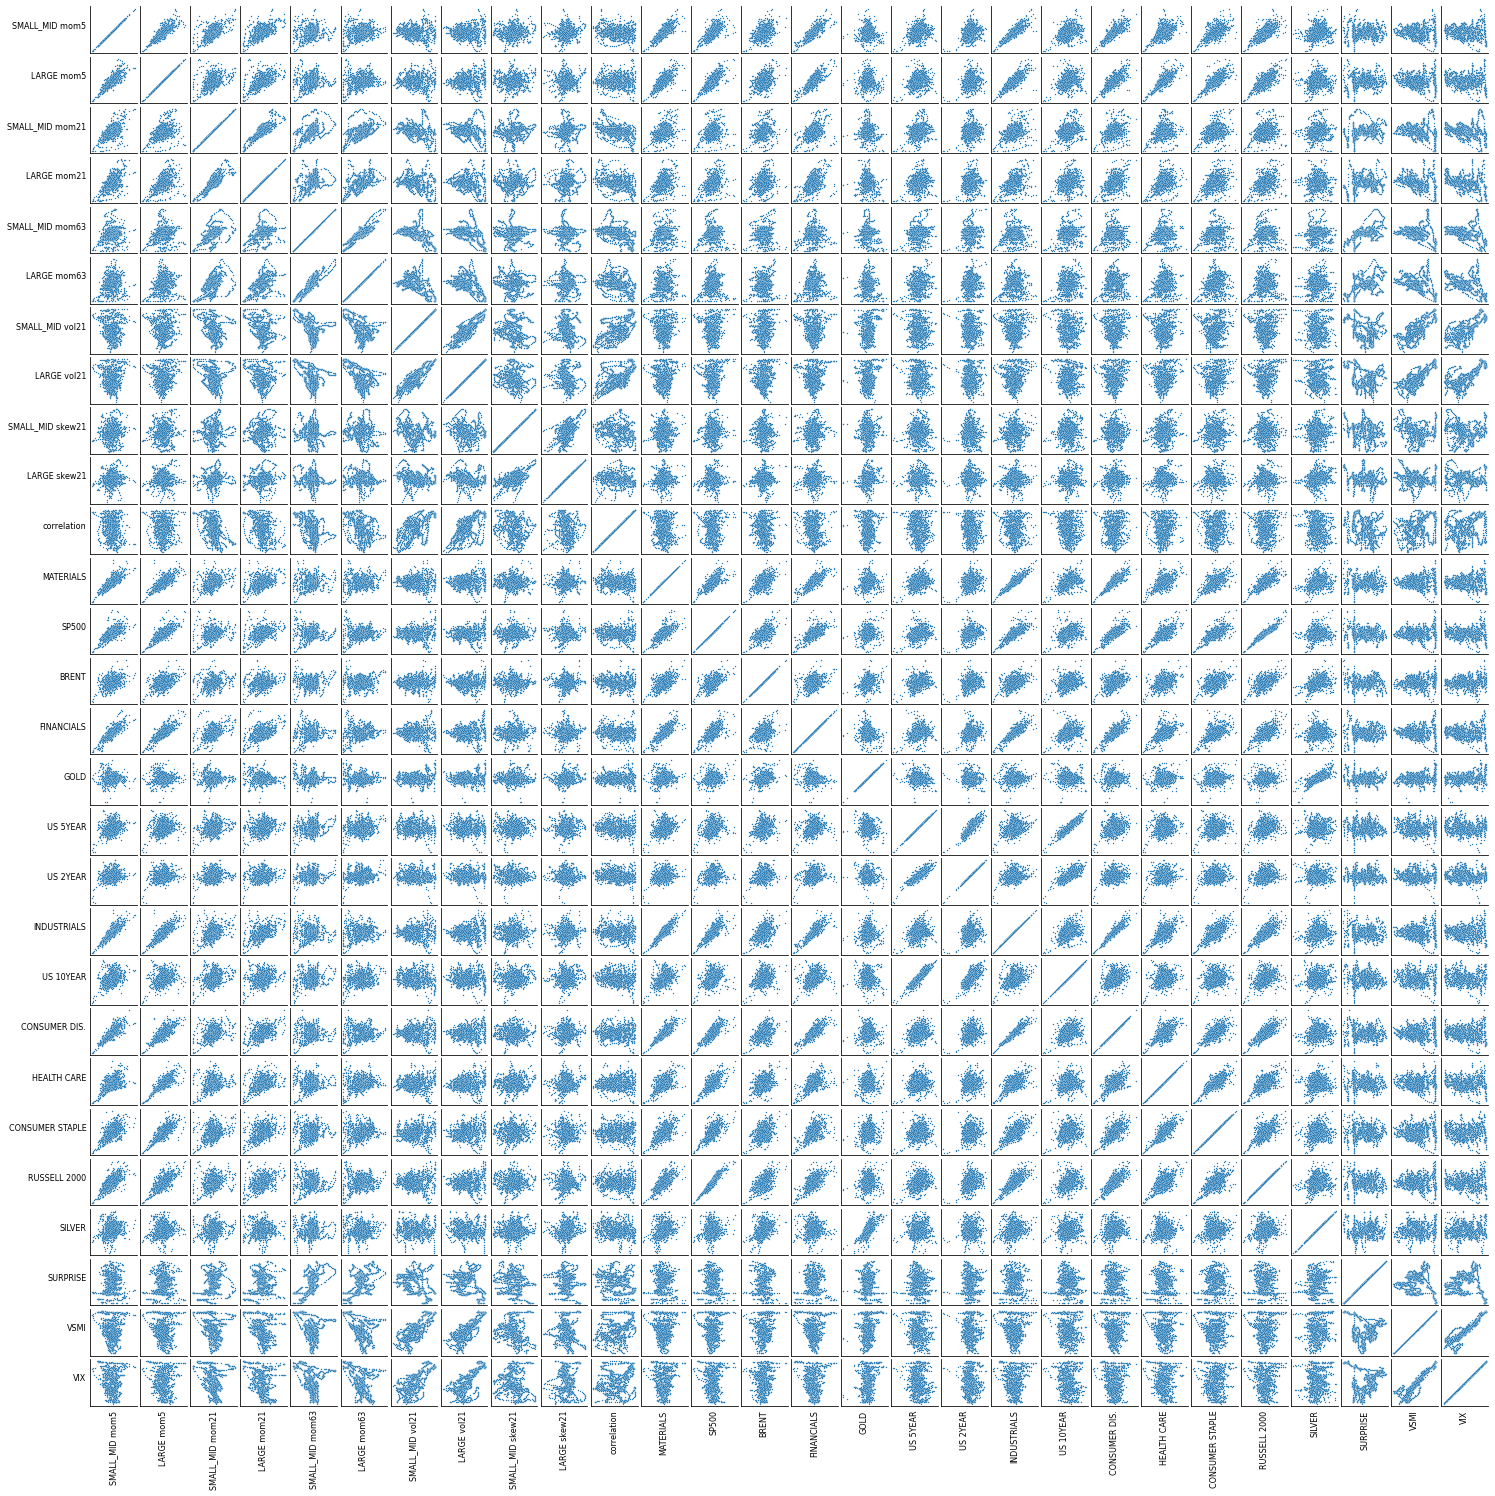

In [67]:
pairplot_data = pd.DataFrame(features_std[features.columns[:]], columns=features.columns[:])

g = sns.pairplot(data=pairplot_data, plot_kws={'s': 2}, diag_kind=None)
g.figure.set_size_inches(20, 20)
plt.setp(g.axes, xticks=[], yticks=[])
for ax in g.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), fontsize=8, rotation=90)
    ax.set_ylabel(ax.get_ylabel(), fontsize=8, rotation=0)
    ax.yaxis.get_label().set_horizontalalignment('right')

plt.savefig('plots/latex/bivariate.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# PCA

In [81]:
pca = PCA(n_components=20)
pca.fit(features_std)

PCA(n_components=20)

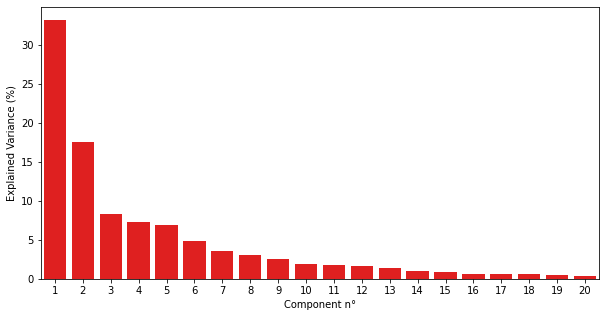

In [82]:
explained_variance = pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=np.arange(20) + 1, y=100 * explained_variance, orient='v', color='red')
#plt.plot(np.cumsum(explained_variance), label='Cumulative Explained Variance')
plt.xlabel('Component n°')
plt.ylabel('Explained Variance (%)')
plt.savefig('plots/latex/pca_components.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [83]:
explained_variance[:3].sum()

0.5896602228978005

In [71]:
loadings = pca.components_.T[:, :4]
df_loadings = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3', 'PC4'], index=features.columns)

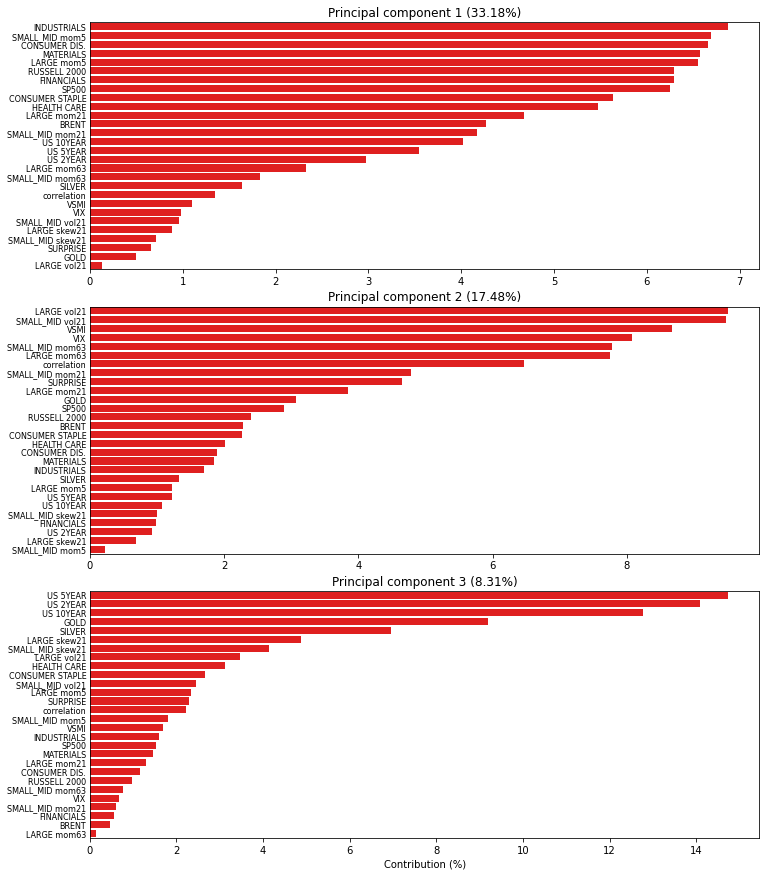

In [72]:
fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=False)

pca_importance = df_loadings.PC1.abs().sort_values(ascending=False)
pca_importance = 100 * pca_importance / pca_importance.sum()
sns.barplot(ax=axs[0], y=pca_importance.index, x=pca_importance.values, color='red')
axs[0].tick_params(axis='y', labelsize=8, length=0)
#axs[0].set_xlabel('Contribution (%)')
axs[0].set_title(f'Principal component 1 ({100 * explained_variance[0]:.2f}%)')

pca_importance = df_loadings.PC2.abs().sort_values(ascending=False)
pca_importance = 100 * pca_importance / pca_importance.sum()
sns.barplot(ax=axs[1], y=pca_importance.index, x=pca_importance.values, color='red')
axs[1].tick_params(axis='y', labelsize=8, length=0)
#axs[1].set_xlabel('Contribution (%)')
axs[1].set_title(f'Principal component 2 ({100 * explained_variance[1]:.2f}%)')
    
pca_importance = df_loadings.PC3.abs().sort_values(ascending=False)
pca_importance = 100 * pca_importance / pca_importance.sum()
sns.barplot(ax=axs[2], y=pca_importance.index, x=pca_importance.values, color='red')
axs[2].tick_params(axis='y', labelsize=8, length=0)
axs[2].set_xlabel('Contribution (%)')
axs[2].set_title(f'Principal component 3 ({100 * explained_variance[2]:.2f}%)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('plots/latex/pca_features_contrib.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [73]:
features_std = features_std.drop(columns=['VIX', 'US 10YEAR', 'SP500', 'MATERIALS', 'CONSUMER DIS.'])

# LOGIT REGRESSION

In [189]:
y = df_output.values

X = features_std.values

split_date = '2012-12-31'
split_index = index.get_loc(split_date, method='ffill')
X_train, y_train, X_test, y_test = X[:split_index], y[:split_index], X[split_index:], y[split_index:]

print('start_date', index[0].date(), '; split date', index[len(X_train)].date(), '; last_date', index[-1].date())

print('Number of train sample :', len(X_train))
print('Number of test sample :', len(X_test))

class_count_train = np.unique(y_train, axis=0, return_counts=True)[1]
class_count_test = np.unique(y_test, axis=0, return_counts=True)[1]
weights_train = class_count_train / sum(class_count_train)
weights_test = class_count_test / sum(class_count_test)
print('Allocation of best returns in train set :', weights_train)
print('Allocation of best returns in test set :', weights_test)

start_date 2009-01-01 ; split date 2012-12-31 ; last_date 2013-11-20
Number of train sample : 819
Number of test sample : 479
Allocation of best returns in train set : [0.505 0.495]
Allocation of best returns in test set : [0.506 0.494]


In [193]:
y

array([1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,

In [192]:
from sklearn.utils import resample
X_train.shape

(819, 21)

In [75]:
logreg = LogisticRegression(penalty='l2', class_weight='balanced')

logreg = logreg.fit(X_train, y_train)
y_hat_logreg_train = logreg.predict(X_train)
y_hat_logreg_test = logreg.predict(X_test)

print('Accuracy on train set', round(100 * output_to_accu_sklearn(logreg, X_train, y_train), 2), '%')
print('Accuracy on test set', round(100 * output_to_accu_sklearn(logreg, X_test, y_test), 2), '%')

Accuracy on train set 72.48 %
Accuracy on test set 53.33 %


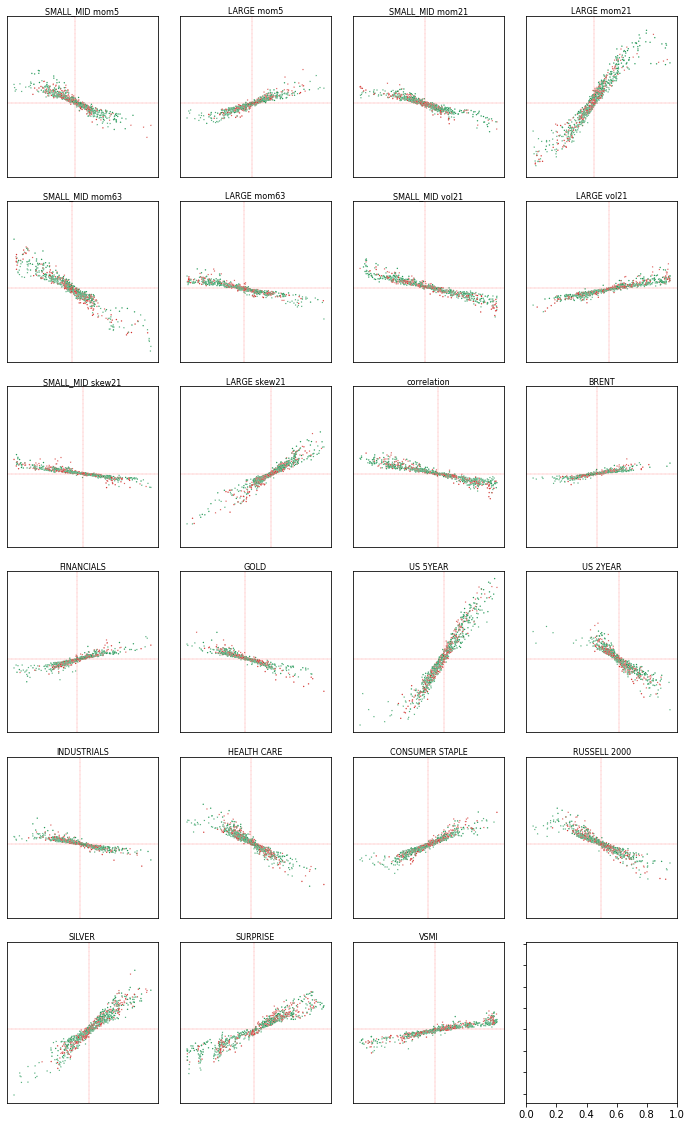

In [25]:
explainer = shap.Explainer(logreg.predict, X_train)
shap_values_train = explainer(X_train).values
good_bad = good_bad_pred_sklearn(logreg, X_train, y_train)

fig, axs = plt.subplots(math.ceil(len(features_std.columns) / 4), 4, figsize=(12, 20), sharex=False, sharey=True)

axs = axs.ravel()

for i, feature in enumerate(features_std.columns):
    df = pd.DataFrame()
    df['value'] = X_train[:, i]
    df['IG'] = shap_values_train[:, i]
    df['good_bad'] = good_bad
    df['target'] = y_train
    df.good_bad = df.good_bad.replace({0:'Bad', 1:'Good'})
    df.target = df.target.replace({0:'Large', 1:'Small'})
    
    sns.scatterplot(ax=axs[i], data=df, x='value', y='IG', hue='good_bad', style='target', s=2, legend=False, palette=color_dict)
    axs[i].axhline(y=0., linestyle='--', color='r', lw=0.25)
    axs[i].axvline(x=0., linestyle='--', color='r', lw=0.25)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_title(feature, fontsize=8, pad=2)

plt.subplots_adjust(wspace=0.15, hspace=0.15)
    
plt.savefig('plots/LOGIT_features_importances_train.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

# Random Forest

In [26]:
rf_n_estimators = [100]
rf_max_depth = [5, 10, 20]
rf_max_depth.append(None)
rf_min_samples_leaf = [1, 5, 10]
rf_min_samples_split = [2, 10, 20]

rf_grid = {'n_estimators'     : rf_n_estimators,
           'max_depth'        : rf_max_depth, 
           'min_samples_leaf' : rf_min_samples_leaf, 
           'min_samples_split': rf_min_samples_split }

tuning_list = []
for n_estimators in tqdm(rf_n_estimators, position=0):
    for max_depth in tqdm(rf_max_depth, position=1, leave=False):
        for samples_leaf in tqdm(rf_min_samples_leaf, position=2, leave=False):
            for samples_split in tqdm(rf_min_samples_split, position=3, leave=False):
                estimator = RandomForestClassifier(max_depth=max_depth, min_samples_leaf=samples_leaf, 
                                                     min_samples_split=samples_split, n_estimators=n_estimators, random_state=1)
                estimator.fit(X_train, y_train)
                tuning_list.append([n_estimators, max_depth, samples_leaf, samples_split,
                                    np.round(100 * output_to_accu_sklearn(estimator, X_train, y_train), 2),
                                    np.round(100 * output_to_accu_sklearn(estimator, X_test, y_test), 2)
                                   ])
                
display(pd.DataFrame(data=tuning_list, columns=['n_estimators', 'max_depth', 'samples_leaf',
                                                'samples_split', 'Train Accuracy', 'Test Accuracy']).sort_values('Test Accuracy').tail())


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

,n_estimators,max_depth,samples_leaf,samples_split,Train Accuracy,Test Accuracy
21,100,20.0,5,2,97.95,60.16
30,100,NaN,5,2,97.95,60.16
31,100,NaN,5,10,97.95,60.16
3,100,5.0,5,2,88.47,62.93
4,100,5.0,5,10,88.47,62.93


In [26]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=5, 
                             min_samples_split=10, random_state=1)
rfc.fit(X_train, y_train)
#rfc_isotonic = CalibratedClassifierCV(rfc, method="isotonic")
#rfc_isotonic.fit(X_train, y_train)

print('Accuracy on train set', round(100 * output_to_accu_sklearn(rfc, X_train, y_train), 2), '%')
print('Accuracy on test set', round(100 * output_to_accu_sklearn(rfc, X_test, y_test), 2), '%')

Accuracy on train set 88.47 %
Accuracy on test set 62.93 %


In [27]:
rfc.fit(X_train, y_train)
rf_importances = rfc.feature_importances_
logic_importances = np.abs(logreg.coef_.reshape(-1) / X_train.std(axis=0))

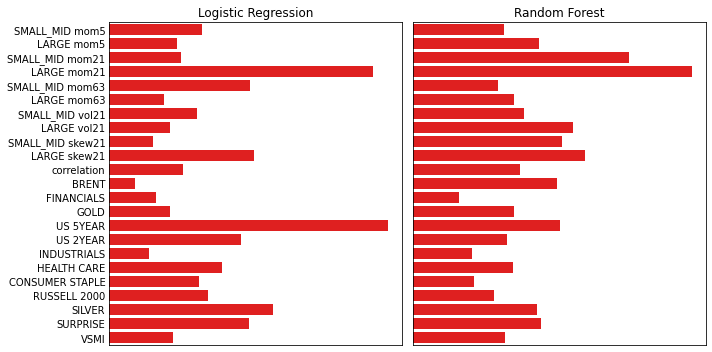

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

sns.barplot(ax=axs[0], x=logic_importances, y=features_std.columns, color='r')
axs[0].tick_params(length=0)
axs[0].set_title('Logistic Regression')

sns.barplot(ax=axs[1], x=rf_importances, y=features_std.columns, color='r')
axs[1].tick_params(length=0)
axs[1].set_title('Random Forest')

plt.setp(axs, xticks=[])
plt.tight_layout()
plt.savefig('plots/latex/global_features_contrib.png', dpi=300, bbox_inches='tight', facecolor='white')

plt.show()

In [29]:
explainer = shap.TreeExplainer(rfc)
shap_values_train = explainer.shap_values(X_train)[1]

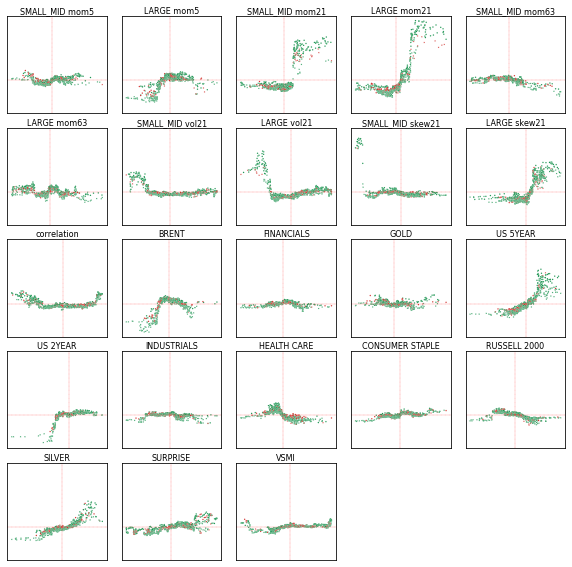

In [30]:
shap_values = shap_values_train
good_bad = good_bad_pred_sklearn(rfc, X_train, y_train)

fig, axs = plt.subplots(math.ceil(len(features_std.columns) / 5), 5, figsize=(10, 10), sharex=False, sharey=True)

axs = axs.ravel()

for i, feature in enumerate(features_std.columns):
    df = pd.DataFrame()
    df['value'] = X_train[:, i]
    df['IG'] = shap_values_train[:, i]
    df['good_bad'] = good_bad
    df['target'] = y_train
    df.good_bad = df.good_bad.replace({0:'Bad', 1:'Good'})
    df.target = df.target.replace({0:'Large', 1:'Small'})
    
    sns.scatterplot(ax=axs[i], data=df, x='value', y='IG', hue='good_bad', style='target', s=2, legend=False, palette=color_dict)
    axs[i].axhline(y=0., linestyle='--', color='r', lw=0.25)
    axs[i].axvline(x=0., linestyle='--', color='r', lw=0.25)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_title(feature, fontsize=8, pad=2)

plt.subplots_adjust(wspace=0.15, hspace=0.15)

fig.delaxes(axs[-2])
fig.delaxes(axs[-1])

plt.savefig('plots/latex/RF_shapley_values', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

# XGBOOST

xg_n_estimators = [1000, 2000]
xg_max_depth = [1, 2]
xg_learning_rate = [0.05, 0.01]

tuning_list = []
for n_estimators in tqdm(xg_n_estimators, position=0, leave=None):
    for max_depth in tqdm(xg_max_depth, position=1, leave=None):
        for lr in tqdm(xg_learning_rate, position=2, leave=None):
            estimator = GradientBoostingClassifier(max_depth=max_depth, learning_rate=lr, 
                                                   n_estimators=n_estimators, random_state=1)
            estimator.fit(X_train, y_train)
            tuning_list.append([max_depth, lr, n_estimators,
                                np.round(100 * output_to_accu_sklearn(estimator, X_test, y_test), 2)])
                
display(pd.DataFrame(data=tuning_list, columns=['max_depth', 'learning_rate', 'n_estimators',
                                                'Accuracy']).sort_values('Accuracy'))



xgboost = GradientBoostingClassifier(max_depth=1, n_estimators=1000, learning_rate=0.01)
xgboost = xgboost.fit(X_train, y_train)

print('Accuracy on train set', round(100 * output_to_accu_sklearn(xgboost, X_train, y_train), 2), '%')
print('Accuracy on test set', round(100 * output_to_accu_sklearn(xgboost, X_test, y_test), 2), '%')

importances = xgboost.feature_importances_

explainer = shap.TreeExplainer(xgboost)
shap_values_train = explainer.shap_values(X_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

sns.barplot(ax=axs[0], x=importances, y=features.columns, color='r')
axs[0].tick_params(length=0)
axs[0].set_title('Global')

sns.barplot(ax=axs[1], x=np.abs(shap_values_train).mean(axis=0), y=features.columns, color='r')
axs[1].tick_params(length=0)
axs[1].set_title('Local (Shapley Value)')

plt.tight_layout()
plt.show()

list_indices = [0, 99]
fig, axs = plt.subplots(1, len(list_indices), figsize=(10, 5), sharey=True, sharex=True)
for i, indice in enumerate(list_indices):
    sns.barplot(ax=axs[i], x=shap_values_train[i], y=features.columns, color='r')
    axs[i].tick_params(length=0)
    axs[i].set_title('Sample number ' + str(indice + 1))
    

shap_values = shap_values_train
good_bad = good_bad_pred_sklearn(xgboost, X_train, y_train)

fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, figsize=(12, 20), sharex=False, sharey=True)

axs = axs.ravel()

for i, feature in enumerate(features.columns):
    df = pd.DataFrame()
    df['value'] = X_train[:, i]
    df['IG'] = shap_values_train[:, i]
    df['good_bad'] = good_bad
    df['target'] = y_train
    df.good_bad = df.good_bad.replace({0:'Bad', 1:'Good'})
    df.target = df.target.replace({0:'Large', 1:'Small'})
    
    sns.scatterplot(ax=axs[i], data=df, x='value', y='IG', hue='good_bad', style='target', s=2, legend=False, palette=color_dict)
    axs[i].axhline(y=0., linestyle='--', color='r', lw=0.25)
    axs[i].axvline(x=0., linestyle='--', color='r', lw=0.25)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_title(feature, fontsize=8, pad=2)

plt.subplots_adjust(wspace=0.15, hspace=0.15)
    
plt.savefig('plots/XG_features_importances_train.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

# Neural Networks

In [31]:
X = torch.from_numpy(X).float()
X_train, y_train, X_test, y_test = torch.from_numpy(X_train).float(), \
                                   torch.from_numpy(y_train).float(), \
                                   torch.from_numpy(X_test).float(), \
                                   torch.from_numpy(y_test).float()

In [32]:
class MLP(nn.Module):
    def __init__(self, nbr_features, num_layers=3, hidden_size=10, pdrop=0.1):
        super().__init__()
        
        self.pdrop = pdrop
        
        self.fc1 = nn.Linear(nbr_features, hidden_size)
        
        self.hidden = nn.ModuleList()
        for k in range(num_layers - 1):
            self.hidden.append(nn.Linear(hidden_size, hidden_size))
        
        self.fc4 = nn.Linear(hidden_size, 1)
        
        self.bn = nn.BatchNorm1d(hidden_size, affine=False)
        self.dropout = nn.Dropout(pdrop)

    def forward(self, x):
        
        x = x.flatten(start_dim=1)
        x = F.relu(self.dropout(self.fc1(x)))
        for layer in self.hidden:
            x = F.relu(self.dropout(layer(x)))
        
        x = torch.sigmoid(self.fc4(x))       

        return x.squeeze()

In [34]:
nbr_features = X_train.size(1)

nb_epochs = 50
batch_size = 20
weight_decay = 1e-4

num_layers_list = [1, 2, 3]
hidden_size_list = [10, 20, 30]
dropout_list = [0.1, 0.2, 0.3]
eta_list = [1e-3]

tuning_list = []
for num_layers in tqdm(num_layers_list, position=0):
    for hidden_size in tqdm(hidden_size_list, position=1, leave=False):
        for dropout in tqdm(dropout_list, position=2, leave=False):
            for eta in tqdm(eta_list, position=3, leave=False):
                
                torch.manual_seed(1)
                model_MLP = MLP(nbr_features, num_layers=num_layers, hidden_size=hidden_size, pdrop=dropout)
                
                train(model_MLP, X_train=X_train, y_train=y_train, nb_epochs=nb_epochs, X_test=X_test, y_test=y_test, 
                      batch_size=batch_size, eta=eta, weight_decay=weight_decay, verbose=0)
                tuning_list.append([num_layers, hidden_size, dropout, eta,
                                    np.round(output_to_accu(model_MLP, X_train, y_train), 2),
                                    np.round(output_to_accu(model_MLP, X_test, y_test), 2)])
                
display(pd.DataFrame(data=tuning_list, columns=['num_layers', 'hidden_size', 'dropout',
                                                'eta', 'Train Accuracy', 'Test Accuracy']).sort_values('Test Accuracy').tail())

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

,num_layers,hidden_size,dropout,eta,Train Accuracy,Test Accuracy
0,1,10,0.1,0.001,73.38,56.18
9,2,10,0.1,0.001,80.34,56.18
11,2,10,0.3,0.001,75.95,56.18
13,2,20,0.2,0.001,79.98,57.30
10,2,10,0.2,0.001,76.31,57.87


In [35]:
torch.manual_seed(1)

nbr_features = X_train.size(1)

nb_epochs = 50
batch_size = 20
weight_decay = 1e-4

nb_epochs=50
num_layers = 2
hidden_size = 10
dropout = 0.2
eta = 0.001
verbose = 3

model_MLP = MLP(nbr_features, num_layers=num_layers, hidden_size=hidden_size, pdrop=dropout)

train(model_MLP, X_train=X_train, y_train=y_train, nb_epochs=nb_epochs, X_test=X_test, y_test=y_test, 
      batch_size=batch_size, eta=eta, weight_decay=weight_decay, verbose=verbose)

model_MLP.eval()
print('number of parameters :', sum(p.numel() for p in model_MLP.parameters() if p.requires_grad))
print(f' MLP Accuracy on train set : {output_to_accu(model_MLP, X_train, y_train):.2f} %')
print(f' MLP Accuracy on test set : {output_to_accu(model_MLP, X_test, y_test):.2f} %')

100%|██████████| 50/50 [00:01<00:00, 31.56it/s]

number of parameters : 361
 MLP Accuracy on train set : 76.31 %
 MLP Accuracy on test set : 57.87 %


In [36]:
ig = IntegratedGradients(model_MLP)
attributes_train = ig.attribute(X_train, return_convergence_delta=False).detach().numpy()
attributes_test = ig.attribute(X_test, return_convergence_delta=False).detach().numpy()

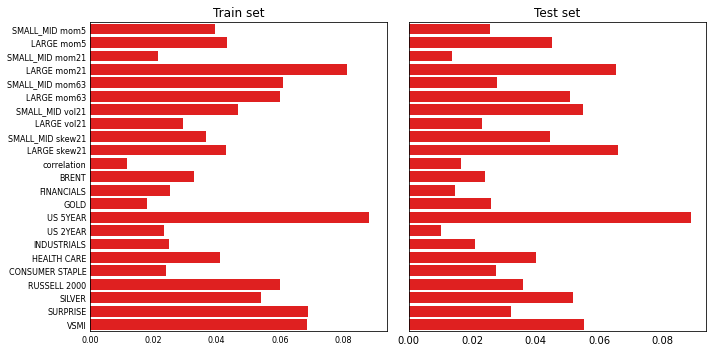

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

attr_train = np.mean(np.abs(attributes_train), axis=0)
attr_test = np.mean(np.abs(attributes_test), axis=0)

sns.barplot(ax=axs[0], x=attr_train, y=features_std.columns, color='r')
axs[0].tick_params(length=0, labelsize=8)
axs[0].set_title('Train set')

sns.barplot(ax=axs[1], x=attr_test, y=features_std.columns, color='r')
axs[1].tick_params(length=0)
axs[1].set_title('Test set')

plt.tight_layout()
plt.show()

shap_values = ShapleyValueSampling(model_MLP)
attributes_train = shap_values.attribute(X_train).detach().numpy()

good_bad = good_bad_pred(model_MLP, X_train, y_train)

fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, figsize=(10, 15), sharex=False, sharey=True)
axs = axs.ravel()

for i, feature in enumerate(features.columns):
    df = pd.DataFrame(columns=['value', 'IG', 'good_bad', 'target', 'categorie'])
    df['value'] = X_train[:, i]
    df['IG'] = attributes_train[:, i]
    df['good_bad'] = good_bad
    df['target'] = y_train
    df.good_bad = df.good_bad.replace({0:'Bad', 1:'Good'})
    df.target = df.target.replace({0:'Large', 1:'Small'})
    
    sns.scatterplot(ax=axs[i], data=df, x='value', y='IG', hue='good_bad', style='target', s=2, legend=False,
                    palette=color_dict, edgecolors=None)
    
    axs[i].axvline(x=0., linestyle='--', color='r', lw=0.25)
    axs[i].axhline(y=0., linestyle='--', color='r', lw=0.25)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_title(feature, fontsize=8, pad=2)

# fig.delaxes(axs[-3])
# fig.delaxes(axs[-2])
# fig.delaxes(axs[-1])

plt.subplots_adjust(wspace=0.15, hspace=0.15)

plt.savefig('plots/MLP_features_importances_train.png', format='png', bbox_inches='tight', dpi=500, facecolor='white')
plt.show()

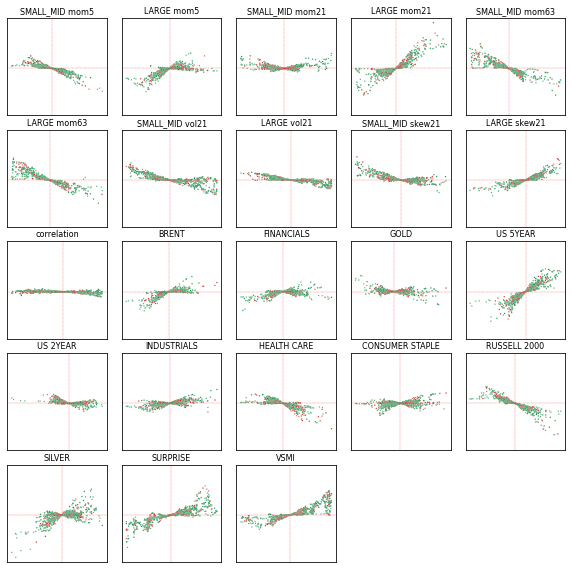

In [49]:
good_bad = good_bad_pred(model_MLP, X_train, y_train)

fig, axs = plt.subplots(math.ceil(len(features_std.columns) / 5), 5, figsize=(10, 10), sharex=False, sharey=True)
axs = axs.ravel()

for i, feature in enumerate(features_std.columns):
    df = pd.DataFrame(columns=['value', 'IG', 'good_bad', 'target', 'categorie'])
    df['value'] = X_train[:, i]
    df['IG'] = attributes_train[:, i]
    df['good_bad'] = good_bad
    df['target'] = y_train
    df.good_bad = df.good_bad.replace({0:'Bad', 1:'Good'})
    df.target = df.target.replace({0:'Large', 1:'Small'})
    
    sns.scatterplot(ax=axs[i], data=df, x='value', y='IG', hue='good_bad', style='target', s=2, legend=False,
                    palette=color_dict, edgecolors=None)
    
    axs[i].axvline(x=0., linestyle='--', color='r', lw=0.25)
    axs[i].axhline(y=0., linestyle='--', color='r', lw=0.25)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_title(feature, fontsize=8, pad=4)
    axs[i].grid(False)

fig.delaxes(axs[-2])
fig.delaxes(axs[-1])

plt.subplots_adjust(wspace=0.15, hspace=0.15)

plt.savefig('plots/latex/MLP_integrated_gradients', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

In [50]:
from itertools import combinations

X = torch.from_numpy(features_std.values).float()
y = torch.from_numpy(df_output.values).float()
X_train, y_train, X_test, y_test = X[:split_index], y[:split_index], X[split_index:], y[split_index:]

list_indices = [2, 10, 12, 13, 16, 18]

results = []

train_accu = np.round(output_to_accu(model_MLP, X_train, y_train), 2)
test_accu = np.round(output_to_accu(model_MLP, X_test, y_test), 2)

for k in range(len(list_indices) + 1):
    for indices in combinations(list_indices, k):
        features_names = [features_std.columns[i] for i in indices]
        X_train, y_train, X_test, y_test = X[:split_index].clone(), y[:split_index].clone(), X[split_index:].clone(), y[split_index:].clone()
        for i in indices:
            X_train[:, i] = torch.zeros(len(X_train))
            X_test[:, i] = torch.zeros(len(X_test))
        results.append([features_names, 
                        train_accu - np.round(output_to_accu(model_MLP, X_train, y_train), 2), 
                        test_accu - np.round(output_to_accu(model_MLP, X_test, y_test), 2)])

display(pd.DataFrame(results, columns=['Features Excluded', 'Train accuracy diff', 'Test accuracy diff']).sort_values('Test accuracy diff'))

X = torch.from_numpy(features_std.values).float()
y = torch.from_numpy(df_output.values).float()
X_train, y_train, X_test, y_test = X[:split_index], y[:split_index], X[split_index:], y[split_index:]

,Features Excluded,Train accuracy diff,Test accuracy diff
24,"[SMALL_MID mom21, correlation, INDUSTRIALS]",1.46,-2.80
63,"[SMALL_MID mom21, correlation, FINANCIALS, GOL...",2.68,-1.68
35,"[correlation, GOLD, INDUSTRIALS]",1.71,-1.68
42,"[SMALL_MID mom21, correlation, FINANCIALS, GOLD]",1.71,-1.68
5,[INDUSTRIALS],0.61,-1.12
10,"[SMALL_MID mom21, INDUSTRIALS]",0.12,-1.12
52,"[correlation, FINANCIALS, GOLD, INDUSTRIALS]",2.32,-1.12
62,"[correlation, FINANCIALS, GOLD, INDUSTRIALS, C...",2.93,-1.12
14,"[correlation, INDUSTRIALS]",0.49,-1.12
23,"[SMALL_MID mom21, correlation, GOLD]",2.56,-0.56


In [45]:
for num_feature in range(1):
#for num_feature in range(len(features.columns)):
    feature = features.columns[num_feature]
    
    torch.manual_seed(1)
    
    model = MLP(nbr_features, num_layers=num_layers, hidden_size=hidden_size, pdrop=dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=eta, weight_decay=weight_decay)
    criterion = nn.BCELoss()

    train_set = TensorDataset(X_train, y_train)    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)

    fig, axs = plt.subplots(5, 5,
                            figsize=(10, 10), sharex=True, sharey=True, constrained_layout=True)
    counter = 0
    for e in (tqdm(range(nb_epochs))):
        if e % 2 == 0:
            model.eval()
            train_accu = output_to_accu(model, X_train, y_train)
            ig = IntegratedGradients(model)
            attributes_train = ig.attribute(X_train, return_convergence_delta=False).detach().numpy()

            good_bad = good_bad_pred(model, X_train, y_train)
            axs = axs.ravel()

            df = pd.DataFrame(columns=['value', 'IG', 'good_bad', 'target', 'categorie'])
            df['value'] = X_train[:, num_feature]
            df['IG'] = attributes_train[:, num_feature]
            df['good_bad'] = good_bad
            df['target'] = y_train
            df.good_bad = df.good_bad.replace({0:'Bad', 1:'Good'})
            df.target = df.target.replace({0:'Large', 1:'Small'})

            sns.scatterplot(ax=axs[counter], data=df, x='value', y='IG', hue='good_bad', style='target', s=3, legend=False,
                            palette=color_dict, edgecolors=None)

            axs[counter].axvline(x=0., linestyle='--', color='r', lw=0.25)
            axs[counter].axhline(y=0., linestyle='--', color='r', lw=0.25)
            axs[counter].set_xlabel(None)
            axs[counter].set_ylabel(None)
            axs[counter].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
            axs[counter].set_title(f'Epoch {e + 1} ; {train_accu:.2f}% Accuracy', fontsize=8, pad=3)
            counter += 1

        model.train()
        for train_input, train_target in train_loader:
            optimizer.zero_grad()
            output = model(train_input)
            loss = criterion(output, train_target)
            loss.backward()
            optimizer.step()

    # plt.suptitle(feature, fontsize=12)
    # plt.savefig(f'plots/features/{feature}.png', format='png', bbox_inches='tight', facecolor='white', dpi=200)
    plt.savefig(f'plots/latex/feature_training.png', format='png', bbox_inches='tight', facecolor='white', dpi=300)
    plt.close()

  0%|          | 0/50 [00:00<?, ?it/s]

from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

model = MLP(nbr_features, pdrop=dropout)
optimizer = torch.optim.Adam(model.parameters(), lr=eta, weight_decay=weight_decay)
criterion = nn.BCELoss()

train_set = TensorDataset(X_train, y_train)    
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)

for e in (tqdm(range(nb_epochs))):
    
    model.eval()
    train_accu = output_to_accu(model, X_train, y_train)
    ig = IntegratedGradients(model)
    attributes_train = ig.attribute(X_train, return_convergence_delta=False).detach().numpy()

    good_bad = good_bad_pred(model, X_train, y_train)
    fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, 
                            figsize=(12, 20), sharex=False, sharey=True, constrained_layout=True)
    axs = axs.ravel()
    for i, feature in enumerate(features.columns):
        df = pd.DataFrame(columns=['value', 'IG', 'good_bad', 'target', 'categorie'])
        df['value'] = X_train[:, i]
        df['IG'] = attributes_train[:, i] / np.abs(X_train[:, i])
        df['good_bad'] = good_bad
        df['target'] = y_train
        df.good_bad = df.good_bad.replace({0:'Bad', 1:'Good'})
        df.target = df.target.replace({0:'Large', 1:'Small'})

        sns.scatterplot(ax=axs[i], data=df, x='value', y='IG', hue='good_bad', style='target', s=3, legend=False,
                        palette=color_dict, edgecolors=None)

        axs[i].axvline(x=0., linestyle='--', color='r', lw=0.25)
        axs[i].axhline(y=0., linestyle='--', color='r', lw=0.25)
        axs[i].set_xlabel(None)
        axs[i].set_ylabel(None)
        axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
        axs[i].set_title(feature, fontsize=8, pad=2)

    # fig.delaxes(axs[-3])
    # fig.delaxes(axs[-2])
    # fig.delaxes(axs[-1])
    plt.suptitle(f'Epoch {e} ; {train_accu:.2f}% Accuracy', fontsize=12)
    plt.savefig('plots/film/' + f'epoch {e}' + '.png', format='png', bbox_inches='tight', facecolor='white')
    plt.close()
    
    model.train()
    for train_input, train_target in train_loader:
        optimizer.zero_grad()
        output = model(train_input)
        loss = criterion(output, train_target)
        loss.backward()
        optimizer.step()

cond1 = LayerConductance(model_MLP, model_MLP.relu1)
cond_vals_train1 = cond1.attribute(X_train).detach().numpy()

cond2 = LayerConductance(model_MLP, model_MLP.relu2)
cond_vals_train2 = cond2.attribute(X_train).detach().numpy()

cond3 = LayerConductance(model_MLP, model_MLP.relu3)
cond_vals_train3 = cond3.attribute(X_train).detach().numpy()

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)

sns.barplot(ax=axs[0], x=np.abs(cond_vals_train1).mean(axis=0), y=np.arange(hidden_size), color='r', orient='h')
axs[0].tick_params(length=0)
axs[0].set_title('Layer 1')

sns.barplot(ax=axs[1], x=np.abs(cond_vals_train2).mean(axis=0), y=np.arange(hidden_size), color='r', orient='h')
axs[1].tick_params(length=0)
axs[1].set_title('Layer 2')

sns.barplot(ax=axs[2], x=np.abs(cond_vals_train3).mean(axis=0), y=np.arange(hidden_size), color='r', orient='h')
axs[2].tick_params(length=0)
axs[2].set_title('Layer 3')

plt.tight_layout()
plt.show()

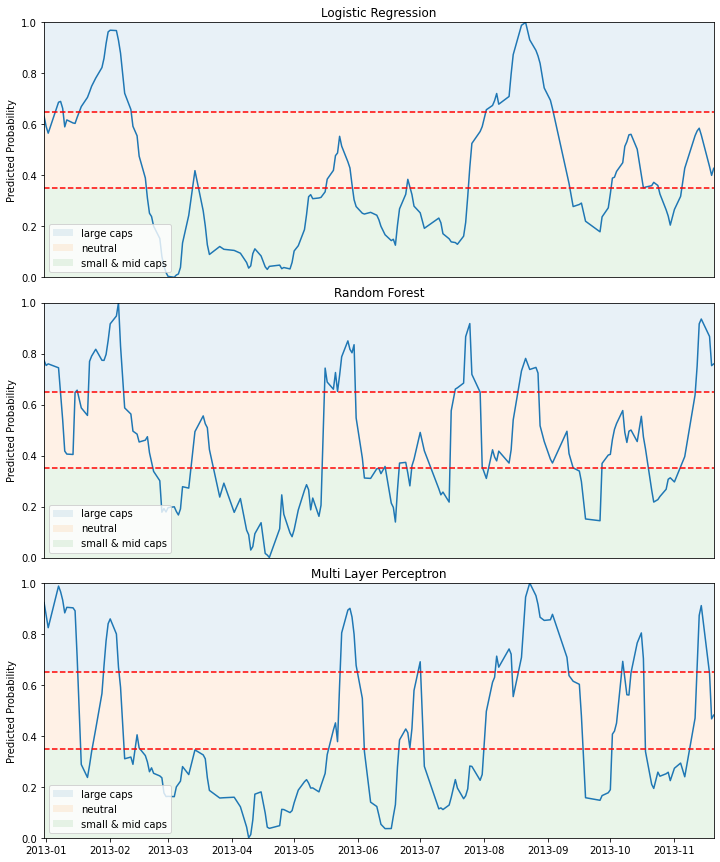

In [49]:
fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharey=True, sharex=True)
top_threshold = 0.65
low_threshold = 0.35

signal = logreg.predict_proba(X_test.detach().numpy())[:, 1]
scaler = MinMaxScaler()
scaler.fit(signal.reshape(-1, 1))
signal = scaler.transform(signal.reshape(-1, 1)).reshape(-1)
test_index = index[split_index:]
axs[0].plot(test_index, signal)
axs[0].axhline(y=top_threshold, linestyle='--', color='r')
axs[0].axhline(y=low_threshold, linestyle='--', color='r')
axs[0].fill_between(x=test_index, y1=top_threshold, y2=1, alpha=0.1, label='large caps')
axs[0].fill_between(x=test_index, y1=low_threshold, y2=top_threshold, alpha=0.1, label='neutral')
axs[0].fill_between(x=test_index, y1=0., y2=low_threshold, alpha=0.1, label='small & mid caps')
axs[0].set_xlim(test_index[0], test_index[-1])
axs[0].set_ylim(0., 1.)
axs[0].set_ylabel('Predicted Probability')
axs[0].set_title('Logistic Regression')
axs[0].legend(loc='lower left')
axs[0].tick_params(axis='x', length=0)

signal = rfc.predict_proba(X_test.detach().numpy())[:, 1]
scaler = MinMaxScaler()
scaler.fit(signal.reshape(-1, 1))
signal = scaler.transform(signal.reshape(-1, 1)).reshape(-1)
test_index = index[split_index:]
axs[1].plot(test_index, signal)
axs[1].axhline(y=top_threshold, linestyle='--', color='r')
axs[1].axhline(y=low_threshold, linestyle='--', color='r')
axs[1].fill_between(x=test_index, y1=top_threshold, y2=1, alpha=0.1, label='large caps')
axs[1].fill_between(x=test_index, y1=low_threshold, y2=top_threshold, alpha=0.1, label='neutral')
axs[1].fill_between(x=test_index, y1=0., y2=low_threshold, alpha=0.1, label='small & mid caps')
axs[1].set_xlim(test_index[0], test_index[-1])
axs[1].set_ylim(0., 1.)
axs[1].set_ylabel('Predicted Probability')
axs[1].set_title('Random Forest')
axs[1].legend(loc='lower left')
axs[1].tick_params(axis='x', length=0)

signal = model_MLP(X_test).detach().numpy()
scaler = MinMaxScaler()
scaler.fit(signal.reshape(-1, 1))
signal = scaler.transform(signal.reshape(-1, 1)).reshape(-1)
test_index = index[split_index:]
axs[2].plot(test_index, signal)
axs[2].axhline(y=top_threshold, linestyle='--', color='r')
axs[2].axhline(y=low_threshold, linestyle='--', color='r')
axs[2].fill_between(x=test_index, y1=top_threshold, y2=1, alpha=0.1, label='large caps')
axs[2].fill_between(x=test_index, y1=low_threshold, y2=top_threshold, alpha=0.1, label='neutral')
axs[2].fill_between(x=test_index, y1=0., y2=low_threshold, alpha=0.1, label='small & mid caps')
axs[2].set_xlim(test_index[0], test_index[-1])
axs[2].set_ylim(0., 1.)
axs[2].set_ylabel('Predicted Probability')
axs[2].set_title('Multi Layer Perceptron')
axs[2].legend(loc='lower left')

plt.subplots_adjust(hspace=0.1)
plt.savefig('plots/latex/signals.png', dpi=300, facecolor='white', bbox_inches='tight')

plt.show()

# Time series as an input

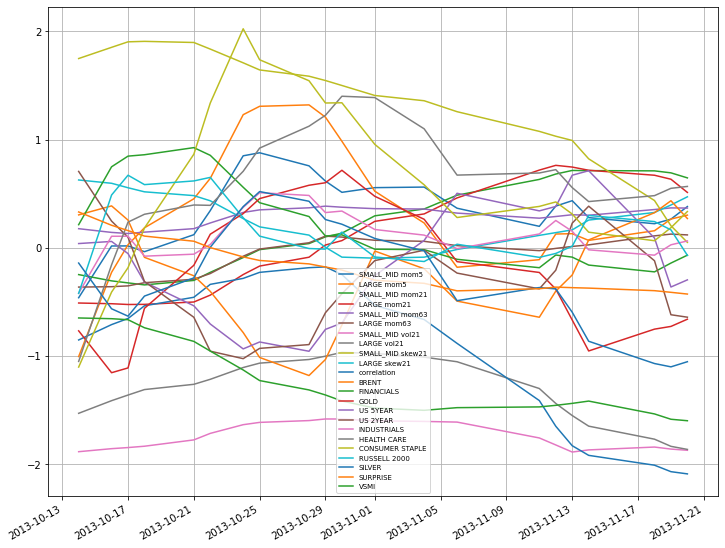

In [76]:
fig, ax = plt.subplots(figsize=(12, 10))
features_std[-21:].plot(ax=ax)
plt.legend(fontsize=7)
plt.grid()
plt.show()

In [145]:
class RNN(nn.Module):

    def __init__(self, nbr_features, hidden_size, num_layers, pdrop=0.):
        super(RNN, self).__init__()
        
        self.nbr_features = nbr_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = pdrop
        self.device = device
        self.rnn = nn.RNN(input_size=self.nbr_features, hidden_size=self.hidden_size, 
                            num_layers=self.num_layers, batch_first=True, dropout=self.dropout)
        self.fc = nn.Linear(hidden_size, 1)

        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(x.size(0), x.size(1), x.size(2))
        x, _ = self.rnn(x)
        x = self.sigmoid(self.fc(x[:, -1, :]))

        return x.squeeze()


class GRU(nn.Module):

    def __init__(self, nbr_features, hidden_size=10, num_layers=1, pdrop=0.):
        super(GRU, self).__init__()
        
        self.nbr_features = nbr_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = pdrop
        self.device = device
        self.gru = nn.GRU(input_size=self.nbr_features, hidden_size=self.hidden_size, 
                            num_layers=self.num_layers, batch_first=True, dropout=self.dropout)
        self.fc = nn.Linear(hidden_size, 1)

        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(x.size(0), x.size(1), x.size(2))
        x, _ = self.gru(x)
        x = self.sigmoid(self.fc(x[:, -1, :]))

        return x.squeeze()

In [146]:
technical_features = data[['SMALL_MID', 'LARGE']]

mom5 = technical_features.rolling(5).apply(lambda x: log_change(x))
mom5 = mom5.add_suffix(' mom5')

mom21 = technical_features.rolling(21).apply(lambda x: log_change(x))
mom21 = mom21.add_suffix(' mom21')

mom63 = technical_features.rolling(63).apply(lambda x: log_change(x))
mom63 = mom63.add_suffix(' mom63')

vol21 = technical_features.pct_change().rolling(21).std()
vol21 = vol21.add_suffix(' vol21')

skew21 = technical_features.pct_change().rolling(21).skew()
skew21 = skew21.add_suffix(' skew21')

corr = target_prices.SMALL_MID.pct_change().rolling(21).corr(target_prices.LARGE.pct_change()).rename('correlation')

features = pd.DataFrame(index=technical_features.index)
for feature in ['MATERIALS', 'SP500', 'BRENT', 'FINANCIALS', 'GOLD', 'US 5YEAR', 
                                'US 2YEAR', 'INDUSTRIALS', 'US 10YEAR', 'CONSUMER DIS.', 'HEALTH CARE', 
                                'CONSUMER STAPLE', 'RUSSELL 2000', 'SILVER']:
    #features[feature] = fast_fracdiff(data[feature], 0.5)
    features[feature] = data[feature].rolling(5).apply(lambda x: log_change(x))

features = pd.concat([mom5, mom21, mom63, vol21, skew21, corr, features, data[['SURPRISE', 'VSMI', 'VIX']]], axis=1).ewm(5).mean().dropna()

features.head(5)

,SMALL_MID mom5,LARGE mom5,SMALL_MID mom21,LARGE mom21,SMALL_MID mom63,LARGE mom63,SMALL_MID vol21,LARGE vol21,SMALL_MID skew21,LARGE skew21,correlation,MATERIALS,SP500,BRENT,FINANCIALS,GOLD,US 5YEAR,US 2YEAR,INDUSTRIALS,US 10YEAR,CONSUMER DIS.,HEALTH CARE,CONSUMER STAPLE,RUSSELL 2000,SILVER,SURPRISE,VSMI,VIX
2006-04-03,0.001734,-0.000138,0.001987,0.000582,0.001972,0.000648,0.004805,0.005994,-0.681978,0.413390,0.550245,0.002142,-0.000306,0.004831,0.000012,0.003677,0.002804,0.002220,0.001047,0.002904,0.000693,-0.000045,-0.000726,0.002206,0.007500,-5.650111,12.005423,11.450572
2006-04-04,0.001879,0.000316,0.002005,0.000638,0.002031,0.000723,0.004822,0.005864,-0.677942,0.450865,0.549831,0.002988,-0.000034,0.005074,0.000644,0.004428,0.002669,0.002203,0.001774,0.002987,0.000980,0.000287,-0.000390,0.002292,0.009026,-4.391748,11.984519,11.470477
2006-04-05,0.002176,0.000543,0.002121,0.000708,0.002041,0.000715,0.004835,0.005769,-0.674858,0.486732,0.547301,0.003563,-0.000435,0.004168,0.000875,0.004309,0.002363,0.001960,0.002144,0.002903,0.000936,0.000160,-0.000256,0.001344,0.009227,-3.009780,11.990433,11.415397
2006-04-06,0.002428,0.000679,0.002302,0.000829,0.002060,0.000741,0.004711,0.005658,-0.614796,0.501623,0.533222,0.003521,-0.000464,0.003403,0.000808,0.003512,0.001699,0.001412,0.002026,0.002336,0.000755,-0.000080,-0.000380,0.000890,0.008279,-1.824810,11.998694,11.367831
2006-04-07,0.002594,0.000873,0.002454,0.000916,0.002100,0.000792,0.004508,0.005548,-0.487867,0.501397,0.515718,0.003883,-0.000382,0.003438,0.000878,0.003212,0.001589,0.001301,0.001985,0.002303,0.000671,-0.000235,-0.000522,0.000429,0.007813,-0.754003,11.987245,11.381526


In [147]:
neutral_threshold = 0.0005

forward_weekly_returns = target_prices.rolling(5).apply(lambda x: np.log(x[-1] / x[0]) / len(x)).shift(-5)
forward_weekly_returns['difference'] = forward_weekly_returns.SMALL_MID - forward_weekly_returns.LARGE
forward_weekly_returns['abs_diff'] = np.abs(forward_weekly_returns.difference)

best_pred = (forward_weekly_returns.SMALL_MID > forward_weekly_returns.LARGE).astype(int)
best_pred = best_pred[forward_weekly_returns.abs_diff > neutral_threshold]

start_date = '2009-01-01'
start_date_input = '2008-12-01'
end_date = '2013-11-20'

df_output = best_pred.loc[start_date:end_date]
df_input = features.loc[start_date_input:end_date]

index = df_output.index
# features = features.reindex(index)
features_std = pd.DataFrame(data=PowerTransformer(method='yeo-johnson', standardize=True).fit_transform(df_input), 
                            columns=features.columns,
                            index=df_input.index)
features_std = features_std.drop(columns=['VIX', 'US 10YEAR', 'SP500', 'MATERIALS', 'CONSUMER DIS.', 'CONSUMER STAPLE', 'FINANCIALS'])


In [148]:
input_period = 21

num_features = len(features_std.columns)

# df_input = features_std.loc[:df_output.index[-1]]

X = []
for idx in df_output.index:
    df_input_period = features_std.loc[:idx].iloc[-input_period:]
    X_period = df_input_period.values.reshape(input_period, num_features)
    X.append(X_period)

X = np.array(X)
y = df_output.values

X, y = torch.from_numpy(X).float(), torch.from_numpy(y).float()

split_date = '2012-12-31'
split_index = index.get_loc(split_date, method='ffill')
X_train, y_train, X_test, y_test = X[:split_index], y[:split_index], X[split_index:], y[split_index:]

100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


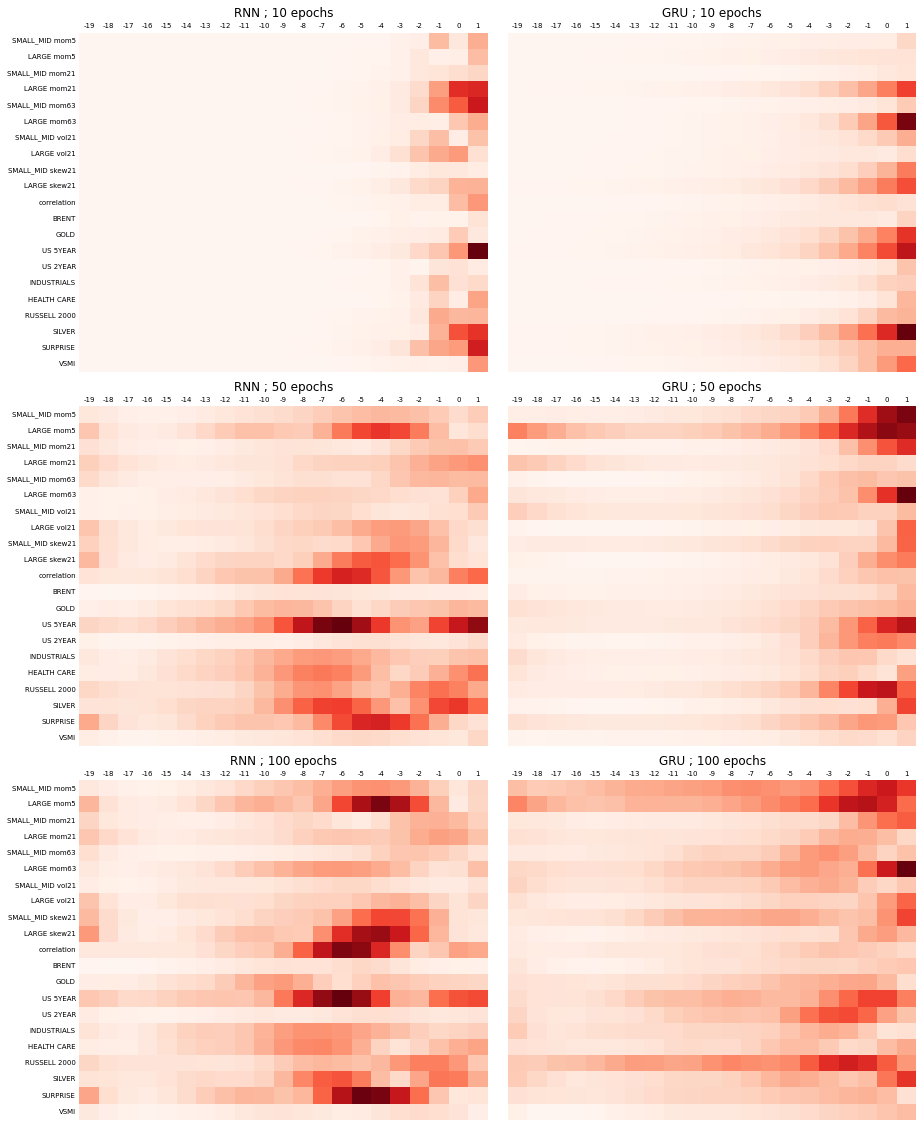

In [181]:
eta = 1e-3
weight_decay = 1e-4
dropout = 0.
batch_size = 20
nb_epochs = 30

verbose = 3

nbr_features = X.size(2)
hidden_size = 10
num_layers = 1

fig, axss = plt.subplots(3, 2, figsize=(15, 20), sharex=True, sharey=True)

for i, nb_epochs in enumerate([10, 50, 100]):
    
    torch.manual_seed(1)
    
    model_RNN = RNN(nbr_features, hidden_size=hidden_size, num_layers=num_layers, pdrop=dropout)
    model_GRU = GRU(nbr_features, hidden_size=hidden_size, num_layers=num_layers, pdrop=dropout)

    train(model_RNN, X_train, y_train, nb_epochs=nb_epochs, X_test=X_test, y_test=y_test, 
          batch_size=batch_size, eta=eta, weight_decay=weight_decay, verbose=verbose)
    train(model_GRU, X_train, y_train, nb_epochs=nb_epochs, X_test=X_test, y_test=y_test, 
          batch_size=batch_size, eta=eta, weight_decay=weight_decay, verbose=verbose)
    
    axs = axss[i, :]
    model_list = [model_RNN, model_GRU]
    for ax, model in zip(axs, model_list):
        ig = IntegratedGradients(model)
        attributes_train = ig.attribute(X_train, return_convergence_delta=False).detach().numpy()

        attr = np.mean(np.abs(attributes_train), axis=0).T

        sns.heatmap(ax=ax, data=attr, annot=False, cmap='Reds', cbar=False, 
                    yticklabels=features_std.columns, xticklabels=list(reversed(- (np.arange(input_period) - 1))))

        ax.tick_params(axis='both', which='major', labelsize=7, labeltop=True, labelbottom=False, rotation=0, length=0)
        ax.set_title(model.__class__.__name__ + f' ; {nb_epochs} epochs', fontsize=12)
        
plt.subplots_adjust(wspace=0.05, hspace=0.1)
plt.savefig(f'plots/latex/rnn_tuning_{hidden_size}.png', dpi=500, facecolor='white', bbox_inches='tight')
plt.show()

100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


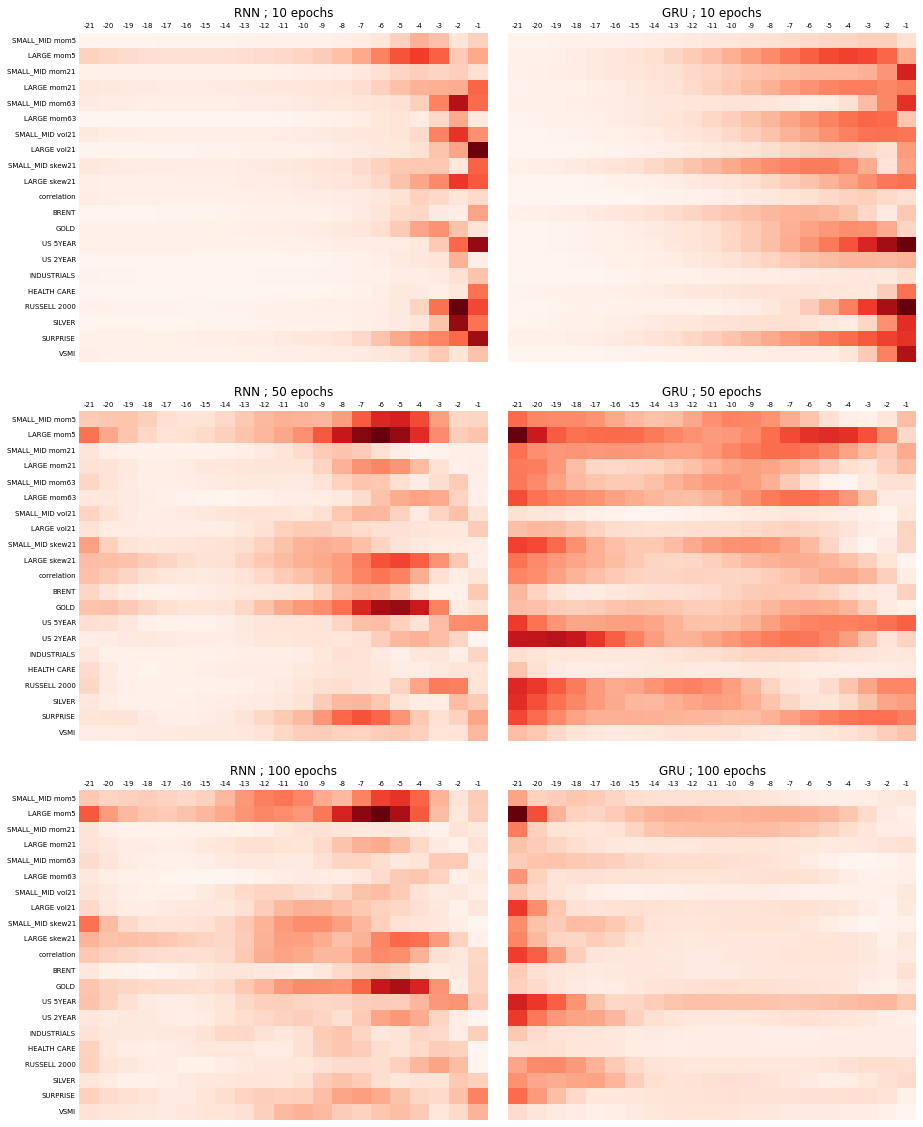

In [182]:
eta = 1e-3
weight_decay = 1e-4
dropout = 0.
batch_size = 20
nb_epochs = 30

verbose = 3

nbr_features = X.size(2)
hidden_size = 20
num_layers = 1

fig, axss = plt.subplots(3, 2, figsize=(15, 20), sharex=True, sharey=True)

for i, nb_epochs in enumerate([10, 50, 100]):
    
    torch.manual_seed(1)
    
    model_RNN = RNN(nbr_features, hidden_size=hidden_size, num_layers=num_layers, pdrop=dropout)
    model_GRU = GRU(nbr_features, hidden_size=hidden_size, num_layers=num_layers, pdrop=dropout)

    train(model_RNN, X_train, y_train, nb_epochs=nb_epochs, X_test=X_test, y_test=y_test, 
          batch_size=batch_size, eta=eta, weight_decay=weight_decay, verbose=verbose)
    train(model_GRU, X_train, y_train, nb_epochs=nb_epochs, X_test=X_test, y_test=y_test, 
          batch_size=batch_size, eta=eta, weight_decay=weight_decay, verbose=verbose)

    
    axs = axss[i, :]
    model_list = [model_RNN, model_GRU]
    for ax, model in zip(axs, model_list):
        ig = IntegratedGradients(model)
        attributes_train = ig.attribute(X_train, return_convergence_delta=False).detach().numpy()

        attr = np.mean(np.abs(attributes_train), axis=0).T

        sns.heatmap(ax=ax, data=attr, annot=False, cmap='Reds', cbar=False, 
                    yticklabels=features_std.columns, xticklabels=list(reversed(- (np.arange(input_period) + 1))))

        ax.tick_params(axis='both', which='major', labelsize=7, labeltop=True, labelbottom=False, rotation=0, length=0)
        ax.set_title(model.__class__.__name__ + f' ; {nb_epochs} epochs', fontsize=12)
        
plt.subplots_adjust(wspace=0.05, hspace=0.15)
plt.savefig(f'plots/latex/rnn_tuning_{hidden_size}.png', dpi=500, facecolor='white', bbox_inches='tight')
plt.show()

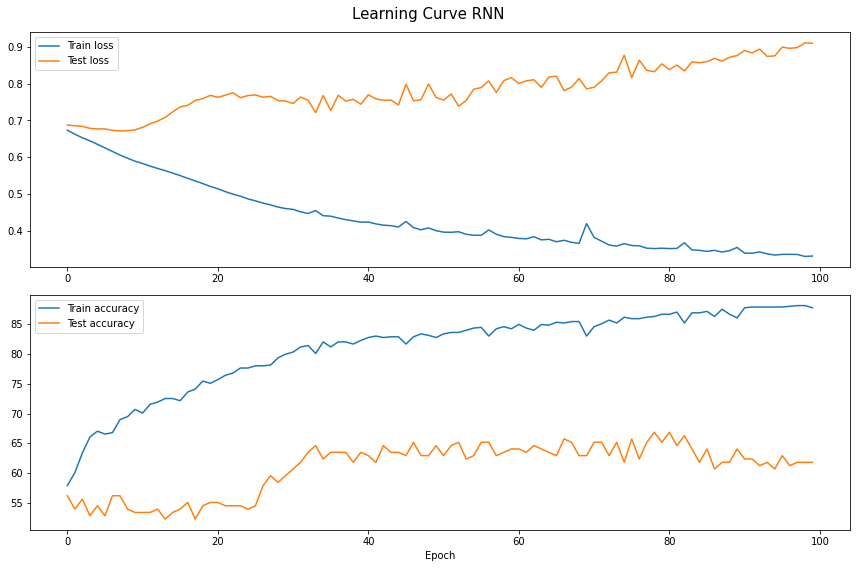

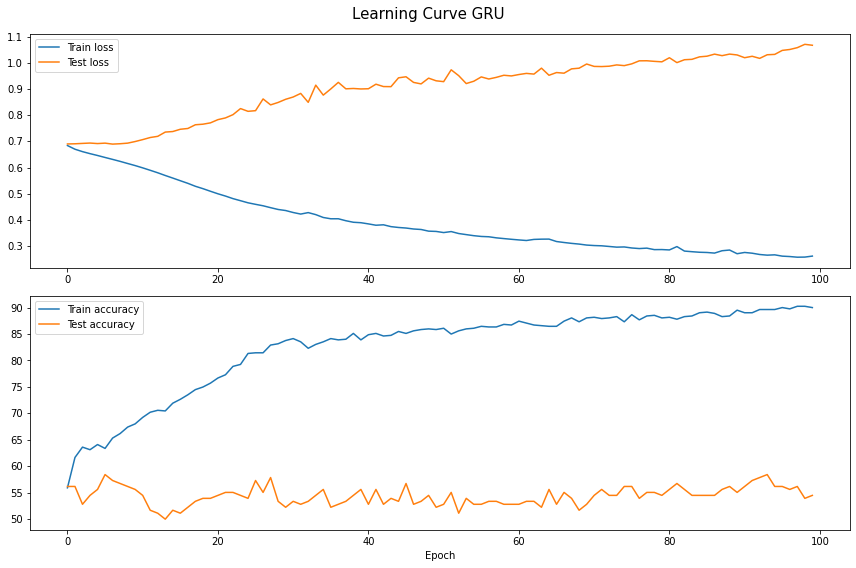

number of parameters : 341
 RNN Accuracy on train set : 87.79 %
 RNN Accuracy on test set : 61.80 %
number of parameters : 1001
 GRU Accuracy on train set : 89.99 %
 GRU Accuracy on test set : 54.49 %


In [186]:
torch.manual_seed(0)

eta = 1e-3
weight_decay = 1e-4
dropout = 0.
batch_size = 20
nb_epochs = 100

verbose = 1

nbr_features = X.size(2)
hidden_size = 10
num_layers = 1

model_RNN = RNN(nbr_features, hidden_size=hidden_size, num_layers=num_layers, pdrop=dropout)
model_GRU = GRU(nbr_features, hidden_size=hidden_size, num_layers=num_layers, pdrop=dropout)

train(model_RNN, X_train, y_train, nb_epochs=nb_epochs, X_test=X_test, y_test=y_test, 
      batch_size=batch_size, eta=eta, weight_decay=weight_decay, verbose=verbose)
train(model_GRU, X_train, y_train, nb_epochs=nb_epochs, X_test=X_test, y_test=y_test, 
      batch_size=batch_size, eta=eta, weight_decay=weight_decay, verbose=verbose)

model_RNN.eval()
print('number of parameters :', sum(p.numel() for p in model_RNN.parameters() if p.requires_grad))
print(f' RNN Accuracy on train set : {output_to_accu(model_RNN, X_train, y_train):.2f} %')
print(f' RNN Accuracy on test set : {output_to_accu(model_RNN, X_test, y_test):.2f} %')

model_GRU.eval()
print('number of parameters :', sum(p.numel() for p in model_GRU.parameters() if p.requires_grad))
print(f' GRU Accuracy on train set : {output_to_accu(model_GRU, X_train, y_train):.2f} %')
print(f' GRU Accuracy on test set : {output_to_accu(model_GRU, X_test, y_test):.2f} %')

In [172]:
ig = IntegratedGradients(model_GRU)
attributes_train = ig.attribute(X_train, return_convergence_delta=False).detach().numpy()
attributes_test = ig.attribute(X_test, return_convergence_delta=False).detach().numpy()

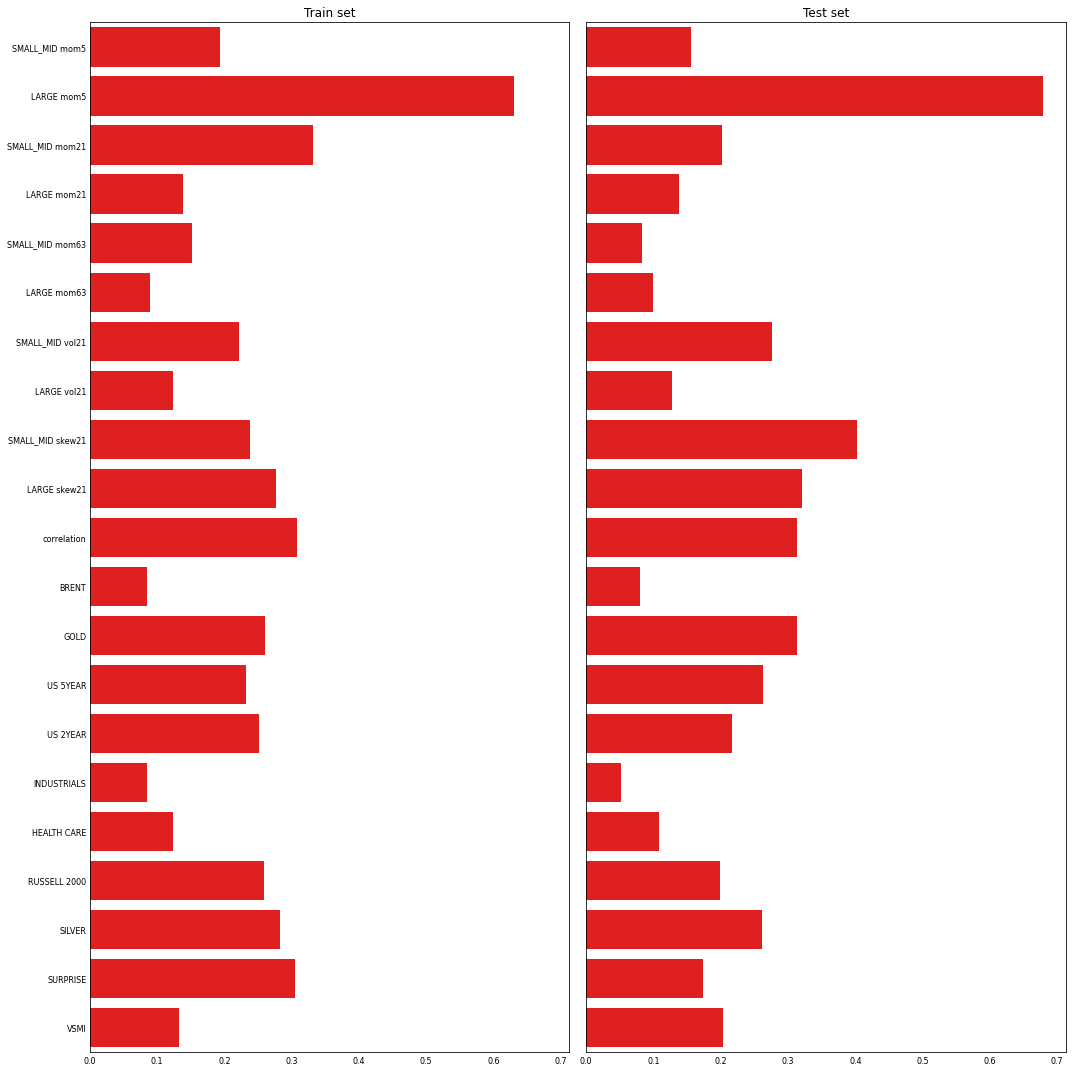

In [173]:
fig, axs = plt.subplots(1, 2, figsize=(15, 15), sharey=True, sharex=True)

attr_train = np.sum(np.mean(np.abs(attributes_train), axis=0), axis=0)
attr_test = np.sum(np.mean(np.abs(attributes_test), axis=0), axis=0)

sns.barplot(ax=axs[0], x=attr_train, y=features_std.columns, color='r')
axs[0].tick_params(length=0, labelsize=8)
axs[0].set_title('Train set')

sns.barplot(ax=axs[1], x=attr_test, y=features_std.columns, color='r')
axs[1].tick_params(length=0, labelsize=8)
axs[1].set_title('Test set')

plt.tight_layout()
plt.show()

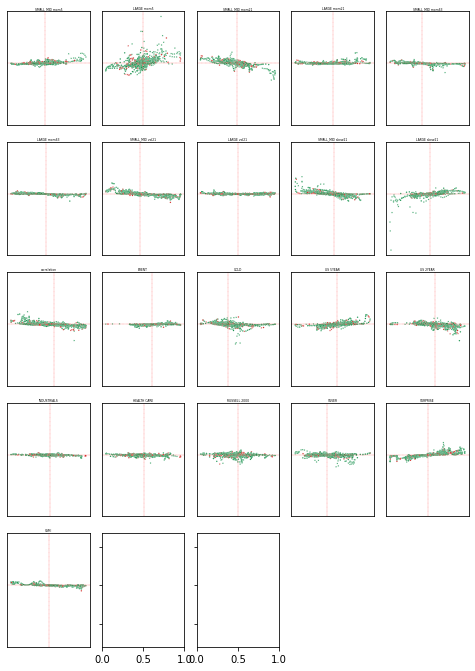

In [174]:
good_bad = good_bad_pred(model_GRU, X_train, y_train)

fig, axs = plt.subplots(math.ceil(len(features_std.columns) / 5), 5, figsize=(8.27, 11.69), sharex=False, sharey=True)
axs = axs.ravel()

for i, feature in enumerate(features_std.columns):
    df = pd.DataFrame()
    df['value'] = X_train.mean(axis=1)[:, i]
    df['IG'] = np.sum(attributes_train, axis=1)[:, i]
    df['GOOD_BAD'] = good_bad
    df.GOOD_BAD = df.GOOD_BAD.replace({0:'Bad', 1:'Good'})
    df['target'] = y_train
    
    sns.scatterplot(ax=axs[i], data=df, x='value', y='IG', hue='GOOD_BAD', style='target',
                    s=2, legend=False, edgecolors=None, palette=color_dict)
    
    axs[i].axvline(x=0., linestyle='--', color='r', lw=0.25)
    axs[i].axhline(y=0., linestyle='--', color='r', lw=0.25)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_title(feature, fontsize=3, pad=2)

fig.delaxes(axs[-2])
fig.delaxes(axs[-1])

plt.subplots_adjust(wspace=0.15, hspace=0.15)

plt.savefig('plots/GRU_features_importances_train.png', format='png', bbox_inches='tight', dpi=500, facecolor='white')
plt.show()

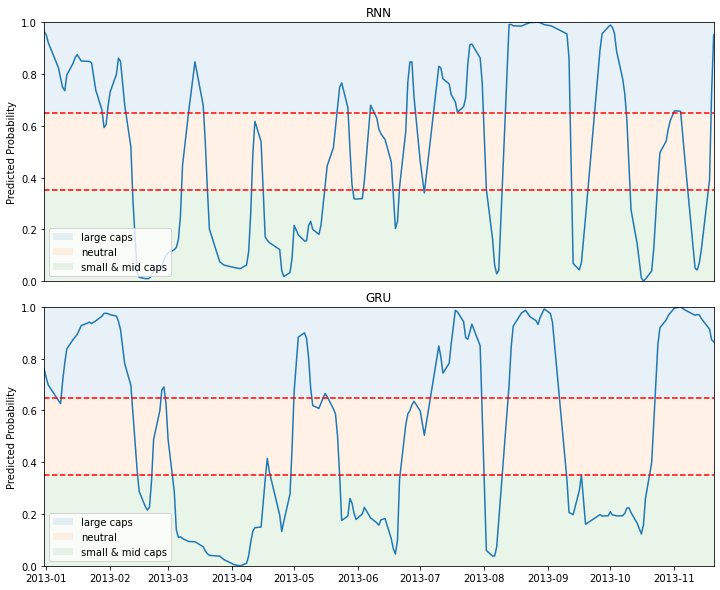

In [177]:
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharey=True, sharex=True)
top_threshold = 0.65
low_threshold = 0.35

signal = model_RNN(X_test).detach().numpy()
scaler = MinMaxScaler()
scaler.fit(signal.reshape(-1, 1))
signal = scaler.transform(signal.reshape(-1, 1)).reshape(-1)
test_index = index[split_index:]
axs[0].plot(test_index, signal)
axs[0].axhline(y=top_threshold, linestyle='--', color='r')
axs[0].axhline(y=low_threshold, linestyle='--', color='r')
axs[0].fill_between(x=test_index, y1=top_threshold, y2=1, alpha=0.1, label='large caps')
axs[0].fill_between(x=test_index, y1=low_threshold, y2=top_threshold, alpha=0.1, label='neutral')
axs[0].fill_between(x=test_index, y1=0., y2=low_threshold, alpha=0.1, label='small & mid caps')
axs[0].set_xlim(test_index[0], test_index[-1])
axs[0].set_ylim(0., 1.)
axs[0].set_ylabel('Predicted Probability')
axs[0].set_title('RNN')
axs[0].legend(loc='lower left')
axs[0].tick_params(axis='x', length=0)

signal = model_GRU(X_test).detach().numpy()
scaler = MinMaxScaler()
scaler.fit(signal.reshape(-1, 1))
signal = scaler.transform(signal.reshape(-1, 1)).reshape(-1)
test_index = index[split_index:]
axs[1].plot(test_index, signal)
axs[1].axhline(y=top_threshold, linestyle='--', color='r')
axs[1].axhline(y=low_threshold, linestyle='--', color='r')
axs[1].fill_between(x=test_index, y1=top_threshold, y2=1, alpha=0.1, label='large caps')
axs[1].fill_between(x=test_index, y1=low_threshold, y2=top_threshold, alpha=0.1, label='neutral')
axs[1].fill_between(x=test_index, y1=0., y2=low_threshold, alpha=0.1, label='small & mid caps')
axs[1].set_xlim(test_index[0], test_index[-1])
axs[1].set_ylim(0., 1.)
axs[1].set_ylabel('Predicted Probability')
axs[1].set_title('GRU')
axs[1].legend(loc='lower left')

plt.subplots_adjust(hspace=0.1)
plt.savefig('plots/latex/signals_rnn.png', dpi=300, facecolor='white', bbox_inches='tight')

plt.show()

<AxesSubplot:>

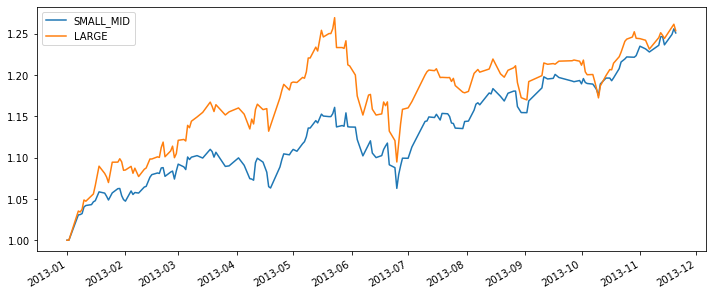

In [144]:
(data[['SMALL_MID', 'LARGE']].loc[test_index].pct_change() + 1).cumprod().plot(figsize=(12, 5))

In [ ]:
fix, ax = plt.subplots(figsize=(15, 5))

plt.plot(model_GRU(X_train).detach().numpy()[-252:])
ax.axhline(y=0.65, linestyle='--', color='r')
ax.axhline(y=0.35, linestyle='--', color='r')
plt.show()

In [ ]:
df_prob = pd.DataFrame(model_GRU(X_train)[-252:].detach())
portfolio = pd.DataFrame(index=df_prob.index, columns=['SMALL_MID', 'LARGE']).fillna(0)

portfolio['SMALL_MID'] = (df_prob > 0.7).astype(int) - (df_prob < 0.3).astype(int)
portfolio['LARGE'] = - portfolio.SMALL_MID
portfolio.head()

In [ ]:
df_trade = pd.DataFrame(index=df_prob.index)
df_trade['small'] = (df_prob > 0.7).astype(int)
df_trade['large'] = (df_prob < 0.3).astype(int)

for i in range(len(df_trade)):
    if df_trade.small.iloc[i] == 1:
        df_trade.at[i, 'strat'] = 1
    elif df_trade.large.iloc[i] == 1:
        df_trade.at[i, 'strat'] = 0
    else:
        df_trade.at[i, 'strat'] = np.nan

df_trade.strat = df_trade.strat.fillna(method='ffill')
df_trade.head(20)